Importing the packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns   
import os 
import openpyxl  
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium.plugins import MarkerCluster
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, Select, CustomJS
from bokeh.layouts import column

Loading the dataset

In [2]:
F1 = pd.read_excel("/Users/angelocapasso/Desktop/F1 Analysis/F1.xlsx", sheet_name = None)
sheet_names = list(F1.keys())
sheets = ['sprint_results', 'results', 'qualifying', 'pitstops', 'driverstandings', 'constructors_results', 'constructors_standing']

### 1) Data Preprocessing

Following, joins between table are made to connect the IDs with their names

In [3]:
F1['races'] = F1['races'].merge(
    F1['circuit'][['circuitId','circuit_name', 'circuit_country']], 
    on='circuitId', 
    how='left'
)
F1['races'] = F1['races'].drop('circuitId', axis=1)

Iterative joins using constructorId, driverId, raceId, statusId

In [4]:
for i in sheets:
    if 'driverId' in F1[i].columns:
        F1[i] = F1[i].merge(
        F1['drivers'][['driverId','surname', 'driver_nationality']], 
        on='driverId', 
        how='left'
        )
        F1[i] = F1[i].drop('driverId', axis = 1)


for i in sheets:
    if 'constructorId' in F1[i].columns:
        F1[i] = F1[i].merge(
        F1['constructors_name'][['constructorId', 'cons_nationality', 'constructor_name']], 
        on='constructorId', 
        how='left'
        )
        F1[i] = F1[i].drop('constructorId', axis = 1)


for i in sheets:
    if 'raceId' in F1[i].columns:
        F1[i] = F1[i].merge(
        F1['races'][['raceId', 'race_name', 'circuit_name', 'year']], 
        on='raceId', 
        how='left'
        )
        F1[i] = F1[i].drop('raceId', axis = 1) 
     

for i in sheets:
    if 'statusId' in F1[i].columns:
        F1[i] = F1[i].merge(
        F1['status'][['statusId', 'status']], 
        on='statusId', 
        how='left'
        )
        F1[i] = F1[i].drop('statusId', axis = 1) 

In [5]:
for i in F1.keys():
    if 'milliseconds' in F1[i]:
        minutes_list = []
        for index, row in F1[i].iterrows():
            if row['milliseconds'] == 'Not available': 
                minutes_list.append(0)
            else:
                minutes_list.append(float(row['milliseconds']) / 60000)
        F1[i]['minutes'] = minutes_list

In [6]:
freq_driver_nationality = F1['drivers']['driver_nationality'].value_counts().reset_index()
freq_driver_nationality.columns = ['driver_nationality', 'Frequency']

# Creazione di un barplot con le frequenze ordinate in modo decrescente
fig = px.bar(freq_driver_nationality, x='driver_nationality', y='Frequency', 
             title="Driver Nationality",
             labels={'Frequency': 'Occurrency', 'Category': 'Nationality'},
             category_orders={'Category': freq_driver_nationality['driver_nationality'].tolist()})


fig.show()

In [7]:
circuit = pd.read_csv(r'/Users/angelocapasso/Desktop/F1 Analysis/circuits.csv')
F1['circuit'][['latitude','longitude','altitude']] = circuit[['lat','lng','alt']].astype(float)
F1['circuit'] = F1['circuit'].drop(['lat','lng','alt'], axis = 1)

In [8]:
m = folium.Map(location=[0, 0], zoom_start=2)

marker_cluster = MarkerCluster().add_to(m)

for _, row in F1['circuit'].iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['location']}",
        tooltip=row['location']
    ).add_to(marker_cluster)


m

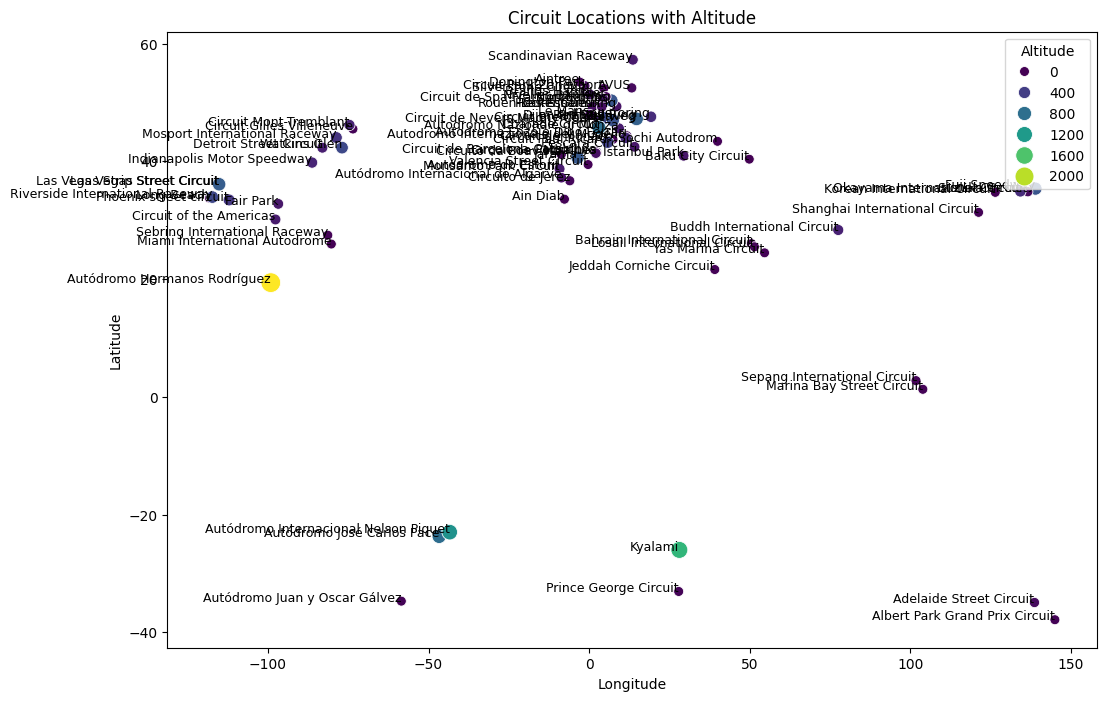

In [9]:
plt.figure(figsize=(12, 8))

circ_plot = sns.scatterplot(
    data=F1['circuit'], 
    x='longitude', 
    y='latitude', 
    hue='altitude',  
    palette='viridis',  
    size='altitude',  
    sizes=(50, 200), 
    legend='brief'
)


for i in range(F1['circuit'].shape[0]):
    circ_plot.text(
        F1['circuit']['longitude'][i], 
        F1['circuit']['latitude'][i], 
        F1['circuit']['circuit_name'][i], 
        fontsize=9, 
        ha='right'
    )


plt.title("Circuit Locations with Altitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Altitude", loc='upper right')
plt.show()

In [10]:
stop_hist = px.bar(F1['pitstops'], x='status', title='Pitstops distribution')
lap_hist = px.histogram(F1['pitstops'], x='lap', title='Lap distribution')


stop_lap = make_subplots(rows=1, cols=2, subplot_titles=('Pitstops distribution', 'Lap distribution'))

for trace in stop_hist['data']:
    stop_lap.add_trace(trace, row=1, col=1)

for trace in lap_hist['data']:
    stop_lap.add_trace(trace, row=1, col=2)

# Aggiornare il layout del subplot
stop_lap.update_layout(title_text="Stops vs Laps", showlegend=False)

# Mostrare il grafico
stop_lap.show()

In [11]:
flop5_pitstops_desc = F1['pitstops'][
    F1['pitstops']['status'] == 'Finished'   
].sort_values(by='minutes', ascending=False).head(5)

flop5desc_plot = px.bar(
    flop5_pitstops_desc,                     
    x='surname',                 
    y='minutes',            
    title='Flop 5 Pistops',
    labels={'minutes': 'Time (minutes)', 'surname': 'Driver'},
    color='surname'              
)

top5_pitstops = F1['pitstops'][
    F1['pitstops']['status'] == 'Finished'   
].sort_values(by='minutes', ascending=True).head(5)

top5desc_plot = px.bar(
    top5_pitstops,                     
    x='surname',                 
    y='minutes',            
    title='Top 5 Pistops',
    labels={'minutes': 'Time (minutes)', 'surname': 'Driver'},
    color='surname'              
)

subplot_pitstops = make_subplots(rows=1, cols=2, subplot_titles=('Flop 5 Pitstops', 'Top 5 Pitstops'))

for trace in flop5desc_plot['data']:
    subplot_pitstops.add_trace(trace, row=1, col=1)

for trace in top5desc_plot['data']:
    subplot_pitstops.add_trace(trace, row=1, col=2)

subplot_pitstops.update_layout(
    title_text='Flop 5 vs Top 5 Pitstops',
    showlegend=False)

subplot_pitstops.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [12]:
F1['qualifying']['podium'] = F1['qualifying']['position'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

surname_podiums = F1['qualifying'].groupby('surname')['podium'].sum()
total_qualifications_pilots = F1['qualifying'].groupby('surname').size()
podium_percentage_pilots = (surname_podiums / total_qualifications_pilots) * 100
top10_pilots_percentage = podium_percentage_pilots.sort_values(ascending=False).head(10)


constructor_podiums = F1['qualifying'].groupby('constructor_name')['podium'].sum()
total_qualifications_constructors = F1['qualifying'].groupby('constructor_name').size()
podium_percentage_constructors = (constructor_podiums / total_qualifications_constructors) * 100
top10_constructors_percentage = podium_percentage_constructors.sort_values(ascending=False).head(10)


qualify_sub = make_subplots(rows=1, cols=2, subplot_titles=("Top 10 Drivers by Podium Percentage", "Top 10 Constructors by Podium Percentage"))

qualify_sub.add_trace(
    go.Bar(x=top10_pilots_percentage.index, y=top10_pilots_percentage, name="Drivers", marker_color='blue'),
    row=1, col=1
)


qualify_sub.add_trace(
    go.Bar(x=top10_constructors_percentage.index, y=top10_constructors_percentage, name="Constructors", marker_color='red'),
    row=1, col=2
)


qualify_sub.update_layout(
    title_text="Top 10 Drivers and Constructors by Podium Percentage",
    showlegend=False,
    xaxis_title="Driver",
    yaxis_title="Podium Percentage (%)",
    xaxis2_title="Constructor",
)


qualify_sub.show()

In [13]:
ferrari_drivers = F1['qualifying'][(F1['qualifying']['surname'].isin(['Leclerc', 'Sainz'])) & 
                                   (F1['qualifying']['constructor_name'] == 'Ferrari')]

leclerc_podiums = ferrari_drivers[(ferrari_drivers['surname'] == 'Leclerc') & (ferrari_drivers['podium'] == 1)]
sainz_podiums = ferrari_drivers[(ferrari_drivers['surname'] == 'Sainz') & (ferrari_drivers['podium'] == 1)]

leclerc_podiums_by_circuit = leclerc_podiums['circuit_name'].value_counts()
sainz_podiums_by_circuit = sainz_podiums['circuit_name'].value_counts()


pie_subplot = make_subplots(rows=1, cols=2, specs=[[{'type':'pie'}, {'type':'pie'}]], 
                    subplot_titles=("Charles Leclerc", "Carlos Sainz"))

pie_subplot.add_trace(
    go.Pie(labels=leclerc_podiums_by_circuit.index, 
           values=leclerc_podiums_by_circuit.values, 
           name="Leclerc"),
    row=1, col=1
)


pie_subplot.add_trace(
    go.Pie(labels=sainz_podiums_by_circuit.index, 
           values=sainz_podiums_by_circuit.values, 
           name="Sainz"),
    row=1, col=2
)


pie_subplot.update_layout(
    title_text="Podium Distribution by Circuit for Ferrari Drivers",
    showlegend=True,
)


pie_subplot.show()

In [16]:
output_notebook()

agg_data_sum = F1['results'].groupby(['year', 'surname'], as_index=False)['points'].sum()
agg_data_mean = F1['results'].groupby(['year', 'surname'], as_index=False)['points'].mean()

source_sum = ColumnDataSource(data=agg_data_sum)
source_mean = ColumnDataSource(data=agg_data_mean)

source = ColumnDataSource(data=dict(source_sum.data))

p = figure(
    title='Sum or Average of Points Over Time by Driver',
    x_axis_label='Year',
    y_axis_label='Points',
    width=800,
    height=400,
    tools="pan,wheel_zoom,box_zoom,reset,save"
)

line = p.line(x='year', y='points', source=source, line_width=2)

p.add_tools(HoverTool(tooltips=[("Year", "@year"), ("Points", "@points"), ("Driver", "@surname")]))

select_driver = Select(title="Select Driver", value="All Drivers", options=["All Drivers"] + agg_data_sum['surname'].unique().tolist())

select_stat = Select(title="Select Statistic", value="Sum", options=["Sum", "Mean"])

callback = CustomJS(args=dict(source=source, source_sum=source_sum, source_mean=source_mean, select_driver=select_driver, select_stat=select_stat), code="""
    const driver = select_driver.value;
    const stat = select_stat.value;
    
    const data_source = (stat === "Sum") ? source_sum.data : source_mean.data;
    
    const filtered = {
        'year': [],
        'points': [],
        'surname': []
    };
    
    for (let i = 0; i < data_source['surname'].length; i++) {
        if (driver === "All Drivers" || data_source['surname'][i] === driver) {
            filtered['year'].push(data_source['year'][i]);
            filtered['points'].push(data_source['points'][i]);
            filtered['surname'].push(data_source['surname'][i]);
        }
    }
    
    source.data = filtered;
    source.change.emit();
""")

select_driver.js_on_change('value', callback)
select_stat.js_on_change('value', callback)

layout = column(select_driver, select_stat, p)
show(layout)

Loading BokehJS ...

In [18]:
output_notebook()

agg_sum_data = F1['results'].groupby(['year', 'constructor_name'], as_index=False)['points'].sum()
agg_mean_data = F1['results'].groupby(['year', 'constructor_name'], as_index=False)['points'].mean()

sum_data_source = ColumnDataSource(data=agg_sum_data)
mean_data_source = ColumnDataSource(data=agg_mean_data)

current_data_source = ColumnDataSource(data=dict(sum_data_source.data))

plot = figure(
    title='Sum or Average of Points Over Time by Constructor',
    x_axis_label='Year',
    y_axis_label='Points',
    width=800,
    height=400,
    tools="pan,wheel_zoom,box_zoom,reset,save"
)


line_graph = plot.line(x='year', y='points', source=current_data_source, line_width=2)


plot.add_tools(HoverTool(tooltips=[("Year", "@year"), ("Points", "@points"), ("Constructor", "@constructor_name")]))


constructor_select = Select(title="Select Constructor", value="All Constructors", options=["All Constructors"] + agg_sum_data['constructor_name'].unique().tolist())


statistic_select = Select(title="Select Statistic", value="Sum", options=["Sum", "Mean"])

update_callback = CustomJS(args=dict(source=current_data_source, sum_source=sum_data_source, mean_source=mean_data_source, constructor_select=constructor_select, statistic_select=statistic_select), code="""
    const selected_constructor = constructor_select.value;
    const selected_statistic = statistic_select.value;
    
    const data_source = (selected_statistic === "Sum") ? sum_source.data : mean_source.data;
    
    const filtered_data = {
        'year': [],
        'points': [],
        'constructor_name': []
    };
    
    for (let i = 0; i < data_source['constructor_name'].length; i++) {
        if (selected_constructor === "All Constructors" || data_source['constructor_name'][i] === selected_constructor) {
            filtered_data['year'].push(data_source['year'][i]);
            filtered_data['points'].push(data_source['points'][i]);
            filtered_data['constructor_name'].push(data_source['constructor_name'][i]);
        }
    }
    
    source.data = filtered_data;
    source.change.emit();
""")

constructor_select.js_on_change('value', update_callback)
statistic_select.js_on_change('value', update_callback)

layout_cons = column(constructor_select, statistic_select, plot)
show(layout_cons)

Loading BokehJS ...

In [17]:
F1['results']

,resultId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,...,fastestLapSpeed,surname,driver_nationality,cons_nationality,constructor_name,race_name,circuit_name,year,status,minutes
0,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,...,1900-01-09 07:00:00,Hamilton,British,British,McLaren,Australian Grand Prix,Albert Park Grand Prix Circuit,2008,Finished,94.843600
1,2,3,5,2,2,2,8.0,58,+5.478,5696094,...,1900-01-09 10:46:00,Heidfeld,German,German,BMW Sauber,Australian Grand Prix,Albert Park Grand Prix Circuit,2008,Finished,94.934900
2,3,7,7,3,3,3,6.0,58,+8.163,5698779,...,1900-01-09 11:59:00,Rosberg,German,British,Williams,Australian Grand Prix,Albert Park Grand Prix Circuit,2008,Finished,94.979650
3,4,5,11,4,4,4,5.0,58,+17.181,5707797,...,1900-01-09 06:44:00,Alonso,Spanish,French,Renault,Australian Grand Prix,Albert Park Grand Prix Circuit,2008,Finished,95.129950
4,5,23,3,5,5,5,4.0,58,+18.014,5708630,...,1900-01-09 08:25:00,Kovalainen,Finnish,British,McLaren,Australian Grand Prix,Albert Park Grand Prix Circuit,2008,Finished,95.143833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26534,26540,77,12,16,16,16,0.0,69,Not available,Not available,...,1900-01-08 06:16:00,Bottas,Finnish,Swiss,Sauber,Hungarian Grand Prix,Hungaroring,2024,+1 Lap,0.000000
26535,26541,2,14,17,17,17,0.0,69,Not available,Not available,...,1900-01-08 15:52:00,Sargeant,American,British,Williams,Hungarian Grand Prix,Hungaroring,2024,+1 Lap,0.000000
26536,26542,31,19,18,18,18,0.0,69,Not available,Not available,...,1900-01-08 05:15:00,Ocon,French,French,Alpine F1 Team,Hungarian Grand Prix,Hungaroring,2024,+1 Lap,0.000000
26537,26543,24,18,19,19,19,0.0,69,Not available,Not available,...,1900-01-08 11:10:00,Zhou,Chinese,Swiss,Sauber,Hungarian Grand Prix,Hungaroring,2024,+1 Lap,0.000000
